Questions:
Build a prediction model to predict whether a movie is going to perform well on our platform (cvt_per_day) based on the information in the dataset.


Summary:

Run four models including ridge regression, SVM, Random Forerst and Xgboost and the result is random forest and Xgboost beat the other two models. Xgboost has the best performance on the training dataset but random forest has better performance on the testing dataset, which may caused by Xgboost naturely has lower bias than baggging models and it also means higher variance. So I decide use random forest as final selected model. 

The ten most important features are 'weighted_categorical_position', 'imdb_votes' 'weighted_horizontal_poition', 'boxoffice', 'budget', 'star_category''metacritic_score', '2012-2013', 'imdb_rating' and 'duration_in_mins'.

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
path = "/content/drive/My Drive/TVdata (1).txt"
df0 = pd.read_csv(path)

## **1. Understand the data**


In [0]:
df1 = df0.copy()

In [43]:
print(df1.dtypes)
print("number of rows: ",df1.shape[0])
print("number of columns: ", df1.shape[1])

video_id                           int64
cvt_per_day                      float64
weighted_categorical_position      int64
weighted_horizontal_poition        int64
import_id                         object
release_year                       int64
genres                            object
imdb_votes                         int64
budget                             int64
boxoffice                          int64
imdb_rating                      float64
duration_in_mins                 float64
metacritic_score                   int64
awards                            object
mpaa                              object
star_category                    float64
dtype: object
number of rows:  4226
number of columns:  16


1.1 check the duplicates

In [44]:
df1.duplicated(subset = 'video_id').any()
print("there is no duplicates base on 'video_id'")

there is no duplicates base on 'video_id'


1.2 check the numaric data corrlation

In [0]:
numaric_features_index = []
for i in range(len(df1.dtypes)):
  if df1.dtypes[i] in ['int64','float64']:
    numaric_features_index.append(i)


In [0]:
numaric_features = df1.columns[numaric_features_index]

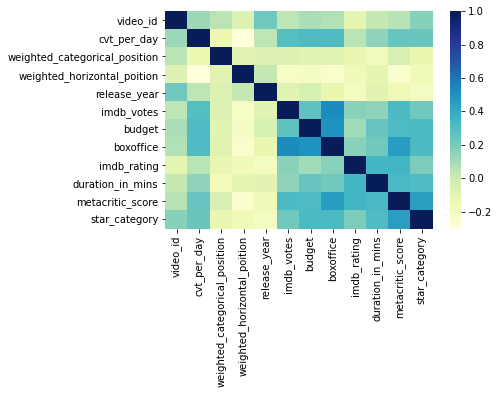

In [47]:
import seaborn as sns
corr= df1[numaric_features].corr()
sns.heatmap(corr, cmap="YlGnBu")

1.3 check the Nan values

In [48]:
df1.isnull().any()

video_id                         False
cvt_per_day                      False
weighted_categorical_position    False
weighted_horizontal_poition      False
import_id                        False
release_year                     False
genres                           False
imdb_votes                       False
budget                           False
boxoffice                        False
imdb_rating                      False
duration_in_mins                 False
metacritic_score                 False
awards                           False
mpaa                             False
star_category                    False
dtype: bool

In [49]:
pd.set_option('max_columns', None)
print(df1.describe(percentiles = [.1, .25, .5, .75, .95]))

            video_id    cvt_per_day  weighted_categorical_position  \
count    4226.000000    4226.000000                    4226.000000   
mean   280371.162565    4218.630239                       7.782537   
std    112640.127822   13036.079964                       6.134183   
min      7909.000000       2.187625                       1.000000   
10%     30848.000000     141.984913                       3.000000   
25%    285104.250000     351.168776                       4.000000   
50%    313891.500000    1193.499989                       6.000000   
75%    349345.750000    3356.788816                       9.000000   
95%    386221.750000   14692.833929                      22.000000   
max    394880.000000  307127.605608                      41.000000   

       weighted_horizontal_poition  release_year     imdb_votes        budget  \
count                  4226.000000   4226.000000    4226.000000  4.226000e+03   
mean                     28.103644   2001.056791    6462.924042  2.

each feature in budget, boxoffice, metacritic_score and star_category has about 50% of missing data. They are presented as 0.

1.4 understand the categorical features

['import_id', 'genres', 'awards', 'mpaa']

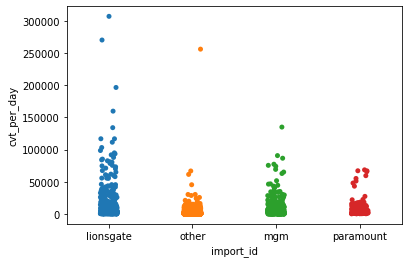

       index  import_id
0      other       2963
1  lionsgate        677
2        mgm        445
3  paramount        141


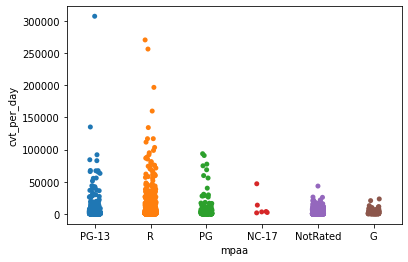

      index  mpaa
0  NotRated  2158
1         R  1158
2     PG-13   426
3        PG   353
4         G   125
5     NC-17     6


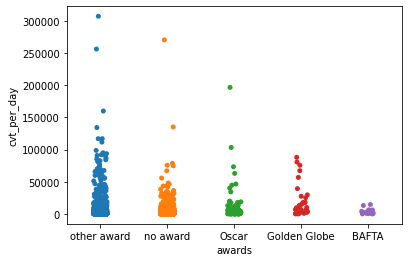

          index  awards
0      no award    2569
1   other award    1453
2         Oscar     141
3  Golden Globe      44
4         BAFTA      19


In [50]:
import matplotlib.pyplot as plt

sns.stripplot(x='import_id', y='cvt_per_day', data=df1, jitter=True)
plt.show()
print(df1['import_id'].value_counts().reset_index())

sns.stripplot(x='mpaa', y='cvt_per_day', data=df1, jitter=True)
plt.show()
print(df1['mpaa'].value_counts().reset_index())

sns.stripplot(x='awards', y='cvt_per_day', data=df1, jitter=True)
plt.show()
print(df1['awards'].value_counts().reset_index())

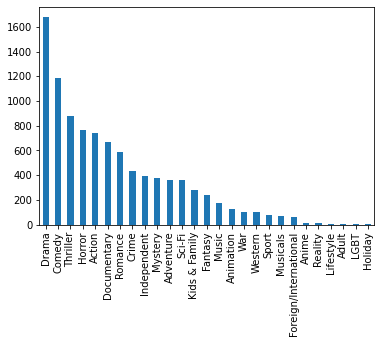

In [51]:
gen_split = df1['genres'].str.get_dummies(sep=',').sum()
gen_split.sort_values(ascending=False).plot.bar()



6 genres including Anime, Reality, Lifestyle, Adult, LGBT, Holiday have low frequencies. Therefore, during feature processing, they will be grouped together as: 'Misc_gen' in the feature 'genres'.

# **2.Feature Preprocessing**

2.1 categorical features to numaric features

In [0]:
d_import_id = pd.get_dummies(df1['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(df1['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(df1.awards).astype(np.int64)

In [0]:
d_genres = pd.DataFrame() 
for genre in ['Action', 'Adult', 'Adventure', 'Animation', 'Anime', 'Comedy', 'Crime', 'Documentary', 'Drama'
          , 'Fantasy', 'Foreign/International', 'Holiday', 'Horror', 'Independent', 'Kids & Family', 'LGBT', 
          'Lifestyle', 'Music', 'Musicals','Mystery', 'Reality', 'Romance','Sci-Fi', 'Sport', 'Thriller', 'War', 
          'Western']:
    gen_lst = []
    for i in range(4226):        
        if genre in df1['genres'][i]:
            gen_lst.append(1)    
        else: 
            gen_lst.append(0)  
    d_genres[genre] = pd.Series(gen_lst).values
    
# combine 6 smallest genres into a new genre 'Misc_gen'
d_genres['Misc_gen'] = d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [54]:
# bin release_year and convert into dummies
max(df1.release_year)

2017

In [0]:
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014,2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']
year_bin = pd.cut(df1['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [0]:
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [57]:
temp = df1.drop(['import_id', 'mpaa','awards','genres', 'release_year'], axis=1)
df2 = pd.concat([temp, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis=1)
df2.shape

(4226, 58)

In [58]:
df2.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_gen,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.605608,1,3,69614,15000000,42930462,6.5,112.301017,51,1.710000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426375,1,3,46705,15000000,3301046,6.5,94.983250,41,3.250000,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867446,1,3,197596,26000000,37397291,7.3,115.763675,58,2.646667,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.720996,3,4,356339,15000000,15700000,7.6,130.703583,94,1.666667,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652064,1,3,46720,27220000,8551228,6.4,105.545533,37,3.066667,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


2.2 handing the missing data

In [0]:
df2[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']] = \
df2[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].replace(0, np.nan)

In [0]:
df2['budget'].fillna(df2['budget'].mean(),inplace = True)
df2['boxoffice'].fillna(df2['boxoffice'].mean(),inplace = True)
df2['metacritic_score'].fillna(df2['metacritic_score'].mean(),inplace = True)
df2['star_category'].fillna(df2['star_category'].mean(),inplace = True)
df2['imdb_votes'].fillna(df2['imdb_votes'].mean(),inplace = True)
df2['imdb_rating'].fillna(df2['imdb_rating'].mean(),inplace = True)

2.3 feature scaling

In [0]:
from sklearn import preprocessing
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
df3 = df2.copy()
sc= preprocessing.StandardScaler().fit(df3[scale_lst])
df3[scale_lst] = sc.transform(df3[scale_lst])

# **3. Model Training**

In [0]:
from sklearn import model_selection
X = df3.drop(['cvt_per_day','video_id'],axis = 1)
y = df3['cvt_per_day']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.15, random_state = 666)

## 3.1 Ridge Regression

In [63]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
ridge = linear_model.Ridge()

params={'alpha': np.logspace (-10, 3, num=150)}
gs_ridge = GridSearchCV(ridge, param_grid=params, verbose=1)
gs_ridge.fit(X_train,y_train)



Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    7.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-10, 1.22249846e-10, 1.49450249e-10, 1.82702700e-10,
       2.23353771e-10, 2.73049642e-10, 3.33802767e-10, 4.08073370e-10,
       4.98869...
       3.28683970e+01, 4.01815648e+01, 4.91219013e+01, 6.00514488e+01,
       7.34128040e+01, 8.97470401e+01, 1.09715619e+02, 1.34127175e+02,
       1.63970266e+02, 2.00453398e+02, 2.45053971e+02, 2.99578103e+02,
       3.66233771e+02, 4.47720223e+02, 5.47337285e+02, 6.69118990e+02,
       8.17996938e+02, 1.00000000e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [64]:
gs_ridge.best_estimator_

Ridge(alpha=245.053971279426, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
best_ridge = gs_ridge.best_estimator_

In [66]:
from sklearn import metrics
ridge_y_hat = best_ridge.predict(X_train)
r2 = metrics.r2_score(y_train,ridge_y_hat)
ridge_mse = metrics.mean_squared_error(y_train,ridge_y_hat)
ridge_r2 = metrics.r2_score(y_train,ridge_y_hat)
print("the mse of ridge is: ",ridge_mse)
print("the r2 of ridge is: ",ridge_r2)

the mse of ridge is:  131357139.12628561
the r2 of ridge is:  0.2615390583340692


## 3.2 Random Forest Regressor

In [0]:
from sklearn import ensemble
rfr = ensemble.RandomForestRegressor(random_state=2, max_features = 'sqrt')

In [68]:
param_grid = {
                 'n_estimators': [54, 55, 56, 57, 58, 59, 60, 62],
                 'max_depth': [12, 13, 14, 15, 16, 17]
             }
rfr_gs = GridSearchCV(rfr,param_grid,n_jobs = -1, verbose = 1)
rfr_gs.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   55.7s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [69]:
rfr_gs.best_params_

{'max_depth': 15, 'n_estimators': 55}

In [70]:
rfr_gs.best_score_

0.5224887575800337

In [71]:
best_rfr = rfr_gs.best_estimator_
rfr_y_hat = best_rfr.predict(X_train)
rfr_mse = metrics.mean_squared_error(y_train,rfr_y_hat)
rfr_r2 = metrics.r2_score(y_train,rfr_y_hat)
print("the mse of rf is: ",rfr_mse)
print("the r2 of rf is: ",rfr_r2)

the mse of rf is:  13693204.048317147
the r2 of rf is:  0.9230198189211283


## 3.3 SVM Regressor

In [0]:
from sklearn import svm
svmr = svm.SVR()

In [73]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

svmr_gs = GridSearchCV(svmr,param_grid,n_jobs = -1, verbose=1)
svmr_gs.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   59.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [74]:
svmr_gs.best_estimator_

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [75]:
svmr_gs.best_score_

0.11039117088996706

In [76]:
best_svm = svmr_gs.best_estimator_
svm_y_hat = best_svm.predict(X_train)
svm_mse = metrics.mean_squared_error(y_train,svm_y_hat)
svm_r2 = metrics.r2_score(y_train,svm_y_hat)
print("the mse of svm is: ",svm_mse)
print("the r2 of svm is: ",svm_r2)

the mse of svm is:  157769787.49655688
the r2 of svm is:  0.11305295916095925


## 3.4 XGboost

In [0]:
from xgboost import XGBRegressor
xgbr = XGBRegressor()

In [0]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}


In [79]:
xgbr.fit(X_train,y_train)

[20:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [80]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold


cv_params = {'n_estimators': [400, 500, 600, 700, 800]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,\
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
xgb_r = XGBRegressor(**other_params)
xgb_gs = GridSearchCV(estimator=xgb_r, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=-1)
xgb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.3min finished


[20:32:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=500, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [400, 500, 600, 700, 800]},
             pre_dispatch='2*n_jobs', refit=True, return_train_s

In [81]:
best_xgb = xgb_gs.best_estimator_
xgb_y_hat = best_xgb.predict(X_train)
xgb_mse = metrics.mean_squared_error(y_train,xgb_y_hat)
xgb_r2 = metrics.r2_score(y_train,xgb_y_hat)
print("the mse of xgboost is: ",xgb_mse)
print("the r-square of xgboost is: ",xgb_r2)

the mse of xgboost is:  1045609.2456990848
the r-square of xgboost is:  0.9941218148223279


## 3.5 evaluation on train dataset
on the training dataset, xgboost and random forest have the better perfomance

In [0]:
all_mse = ['ridge_mse','rfr_mse', 'svm_mse','xgb_mse']
mse_val =  [ridge_mse,rfr_mse, svm_mse,xgb_mse]

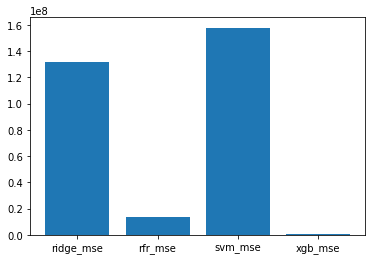

In [83]:
plt.bar(all_mse,mse_val)
plt.show()

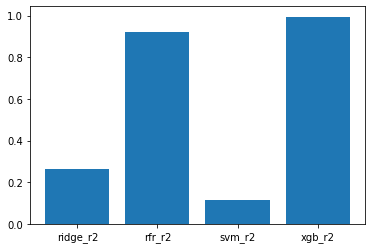

In [84]:
all_r2 = ['ridge_r2','rfr_r2', 'svm_r2','xgb_r2']
r2_val = [ridge_r2,rfr_r2, svm_r2,xgb_r2]
plt.bar(all_r2,r2_val)
plt.show()

## 4. Model Evaluation on testing dataset

4.1 Ridge Performance

In [96]:
ridge_predict = best_ridge.predict(X_test)
ridge_predict_mse = metrics.mean_squared_error(y_test,ridge_predict)
ridge_predict_r2 = metrics.r2_score(y_test,ridge_predict)
print("ridge mse on testing is: ",ridge_predict_mse)
print("ridge r2 on testing is: ",ridge_predict_r2)


ridge mse on testing is:  82093959.06788635
ridge r2 on testing is:  0.3415630584639172


4.2 Random Forest Performance

In [97]:
rf_predict = best_rfr.predict(X_test)
rf_predict_mse = metrics.mean_squared_error(y_test,rf_predict)
rf_predict_r2 = metrics.r2_score(y_test,rf_predict)
print("random forest mse on testing is: ",rf_predict_mse)
print("random forest r2 on testing is: ",rf_predict_r2)

random forest mse on testing is:  49336840.20034211
random forest r2 on testing is:  0.6042924651775585


4.3 SVM Performance

In [98]:
svm_predict = best_svm.predict(X_test)
svm_predict_mse = metrics.mean_squared_error(y_test,svm_predict)
svm_predict_r2 = metrics.r2_score(y_test,svm_predict)
print("SVM mse on testing is: ",svm_predict_mse)
print("SVM r2 on testing is: ",svm_predict_r2)

SVM mse on testing is:  104704910.9491916
SVM r2 on testing is:  0.16021127361900722


4.4 XGBoost Performance

In [99]:
xgb_predict = best_xgb.predict(X_test)
xgb_predict_mse = metrics.mean_squared_error(y_test,xgb_predict)
xgb_predict_r2 = metrics.r2_score(y_test,xgb_predict)
print("xgboost mse on testing is: ",xgb_predict_mse)
print("xgboost r2 on testing is: ",xgb_predict_r2)

xgboost mse on testing is:  49551214.15221053
xgboost r2 on testing is:  0.6025730727787034


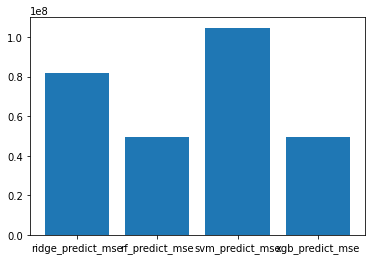

In [100]:
test_mse_val = [ridge_predict_mse,rf_predict_mse,svm_predict_mse,xgb_predict_mse]
test_mse_label = ['ridge_predict_mse','rf_predict_mse','svm_predict_mse','xgb_predict_mse']
plt.bar(test_mse_label,test_mse_val)
plt.show()



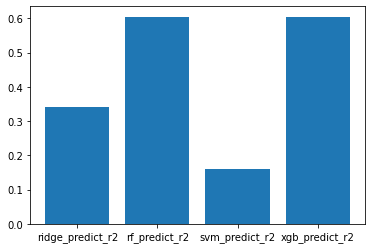

In [101]:
test_r2_val = [ridge_predict_r2,rf_predict_r2,svm_predict_r2,xgb_predict_r2]
test_r2_label = ['ridge_predict_r2','rf_predict_r2','svm_predict_r2','xgb_predict_r2']
plt.bar(test_r2_label,test_r2_val)
plt.show()

# Conclusion: Within 4 models, random forest and xgboost are out performers. Random Forest has slightly better performance than Xgboost in this case. So eventually, I pick the random forest as final forcast algorithm.

In [0]:
index = np.argsort(best_rfr.feature_importances_)
x_axis = best_rfr.feature_importances_[index][-10:]
y_axis = X_test.columns[index][-10:]

<BarContainer object of 10 artists>

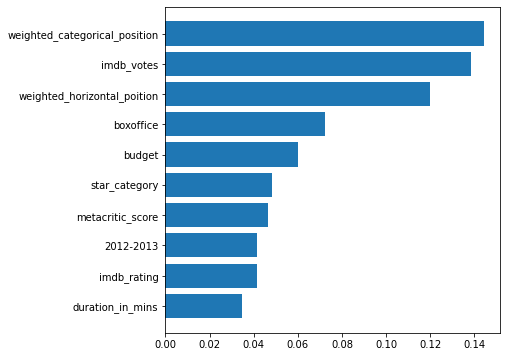

In [153]:
from matplotlib import pyplot
fig = plt.figure(figsize=(6,6)) 
pyplot.barh(y_axis, x_axis)

In [155]:
X_test.columns[index][-10:][::-1]

Index(['weighted_categorical_position', 'imdb_votes',
       'weighted_horizontal_poition', 'boxoffice', 'budget', 'star_category',
       'metacritic_score', '2012-2013', 'imdb_rating', 'duration_in_mins'],
      dtype='object')